# Take the best model

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np

import bayesflow as bf
import json

where $t_q$ is determined by the take the best decision rule defined
below.

### Data

In [2]:
with open(os.path.join("data", "StopSearchData.json")) as f:
    data = json.load(f)

data.keys()

dict_keys(['m', 'nc', 'nq', 'ns', 'p', 'v', 'x', 'y'])

### Simulator

First, we define the “take the best” (TTB) decision rule: For each
question, we loop over its cues in order of their validity (the
questions are already ordered in the data). As soon as a cue prefers
decision ‘a’ or ‘b’, the decision is determined.

In [3]:
def ttb(nq: int, nc: int, p: np.ndarray, m: np.ndarray):
    output = np.zeros(nq) # 0: guessing

    for q in range(nq):
        for c in range(nc):
            cue_a = m[p[q][0]-1][c]
            cue_b = m[p[q][1]-1][c]
            if cue_a > cue_b:
                output[q] = 1 # decision a
                break
            elif cue_a < cue_b:
                output[q] = 2 # decision b
                break

    return output.astype(int)


Applying the decision rule to the data produces the “decision a” for
each question according to TTB: This is because the recorded data had
been already recoded such that choice “a” always corresponds to the
choice according to the TTB rule.

In [4]:
decisions = ttb(data['nq'], data['nc'], data['p'], data['m'])
decisions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

Next, we can define the prior and a likelihood. The only source of
alleatoric uncertainty in our simulator comes from the parameter
$\gamma$, which indicates the probability of responding “a” if the TTB
decision rule indicates to respond “a”, and vice versa.

The shape of the resulting data is (number of participants, number of
questions).

In [5]:
def prior():
    return dict(gamma = np.random.uniform(low=0.5, high=1))
    

def likelihood(
        gamma: float, 
        ns: int = data['ns'],
        nq: int = data['nq'],
        ttb = decisions
        ):
    
    probs = np.array([0.5, gamma, 1-gamma])
    probs = probs[ttb][np.newaxis]
    probs = np.tile(probs, reps=[ns, 1])

    y = np.random.binomial(n=1, p=probs, size=(ns, nq))

    return dict(y=y)

simulator = bf.make_simulator([prior, likelihood])


### Approximator

We will approximate the posterior of $\gamma$, given the observed
decisions $y$.

In [6]:
adapter = (bf.Adapter()
    .constrain("gamma", lower=0.5, upper=1)
    .rename("gamma", "inference_variables")
    .rename("y", "summary_variables")
)

In [ ]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow(),
    summary_network=bf.networks.DeepSet(),
    initial_learning_rate=1e-3
)

### Training

In [ ]:
history = workflow.fit_online(epochs=50, num_batches_per_epoch=500, batch_size=512)

### Validation

In [9]:
test_data = simulator.sample(1000)

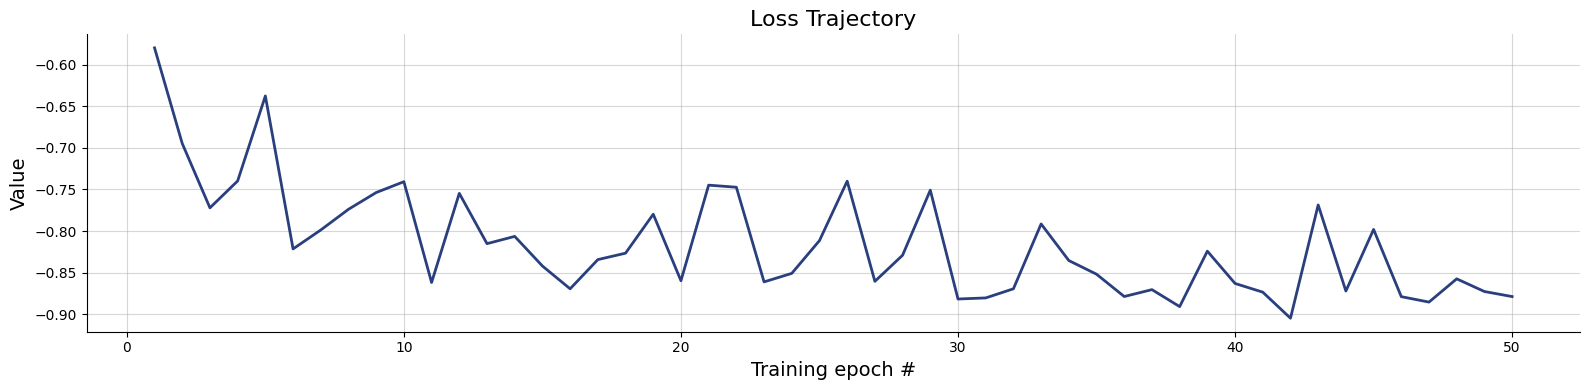

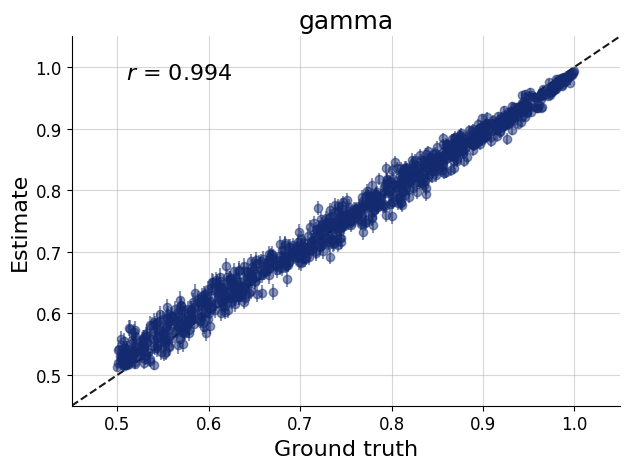

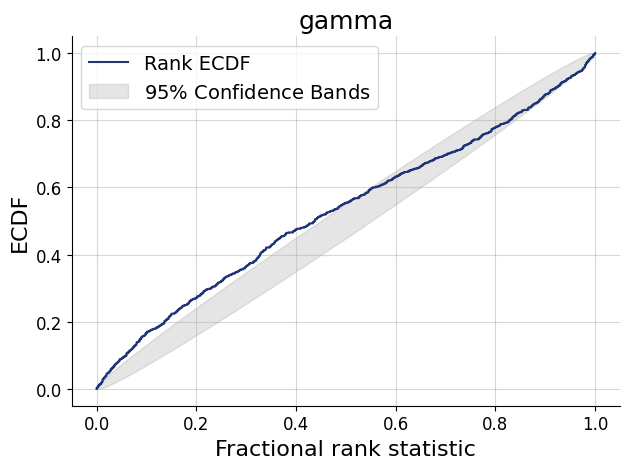

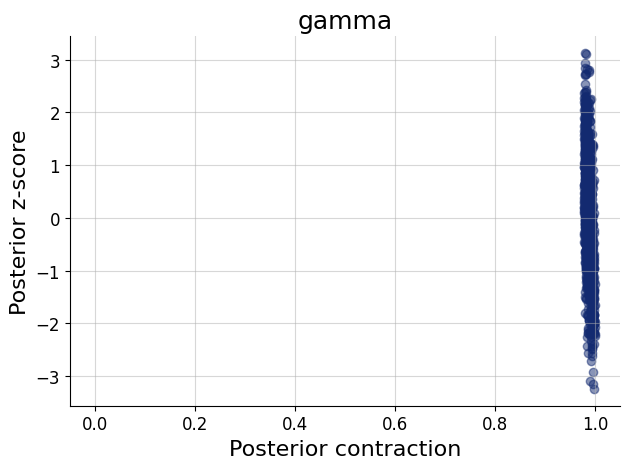

In [10]:
figs=workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

Now we can apply to the model to real data (Lee & Wagenmakers, 2013).

In [17]:
inference_data = dict(y = np.array(data['y'])[np.newaxis])

In [18]:
samples = workflow.sample(num_samples=1000, conditions=inference_data)

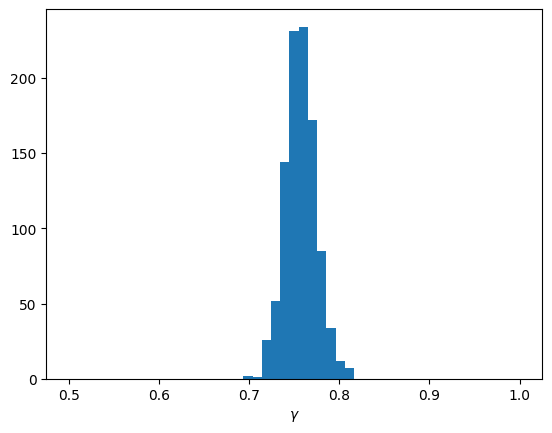

In [28]:
f=plt.hist(samples['gamma'].flatten(), bins=np.linspace(0.5, 1, 50))
f=plt.xlabel(r"$\gamma$")

Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.